In [1]:
import numpy as np
import csv
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
COLORS = list(colors.CSS4_COLORS.keys())
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import warnings
import scipy
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

%matplotlib notebook

In [2]:
def load_region(file):  
    df = pd.read_csv(file)
    df.index = df['timestamp']
    del df['timestamp']
    return df

In [4]:
DAYS = [31,28,31,30,31,30,31,31,30,31,30,31]
DAYS_SUM = [sum(DAYS[0:k]) for k in range(12)]

In [5]:
df = load_region('county1000.csv')

In [6]:
data = np.asarray(df[DAYS_SUM[4]*24*4:DAYS_SUM[7]*24*4]).astype('float16').T

In [7]:
blds, t_len = data.shape

In [8]:
num_days = t_len//(24*4)
num_days

92

In [9]:
data_days = data.reshape(blds,num_days,24*4)

<IPython.core.display.Javascript object>


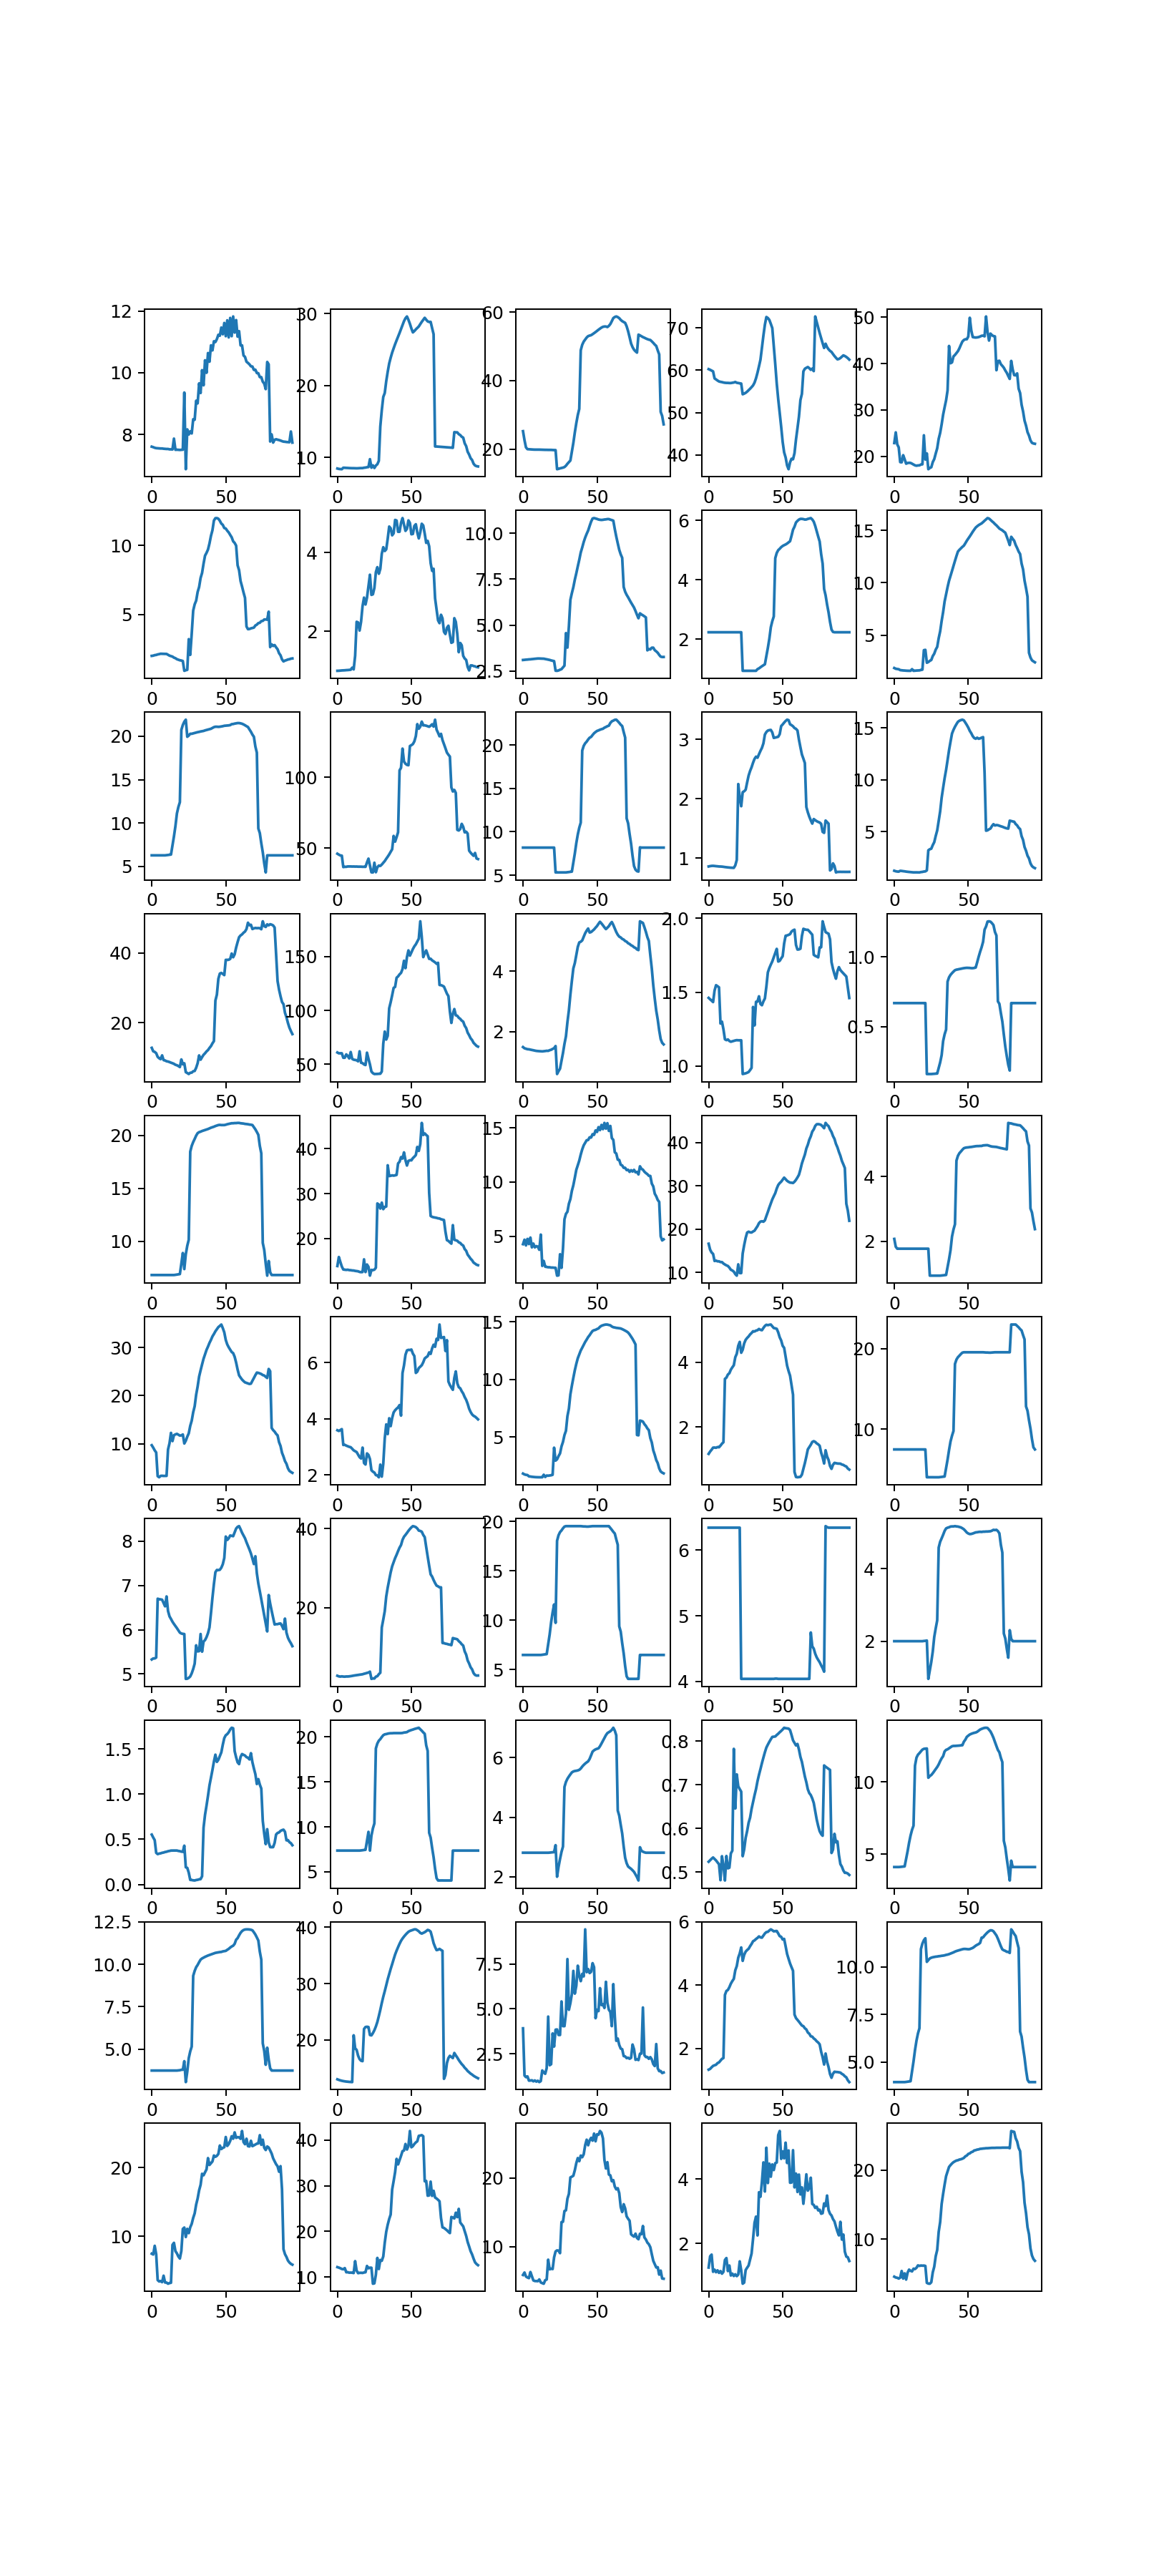

In [10]:
plt.subplots(10,5, figsize = (9,20))
for i in range(50):
    plt.subplot(10,5,i+1)
    bld = np.random.randint(0,blds)
    day = np.random.randint(0,num_days)
    plt.plot(data_days[bld,day,:])

In [16]:
two_days = np.zeros((blds,num_days-1,24*4*2))
for i in range(num_days-1):
    two_days[:,i,:] = np.concatenate([data_days[:,i,:],data_days[:,i+1,:]],axis=1)

<IPython.core.display.Javascript object>


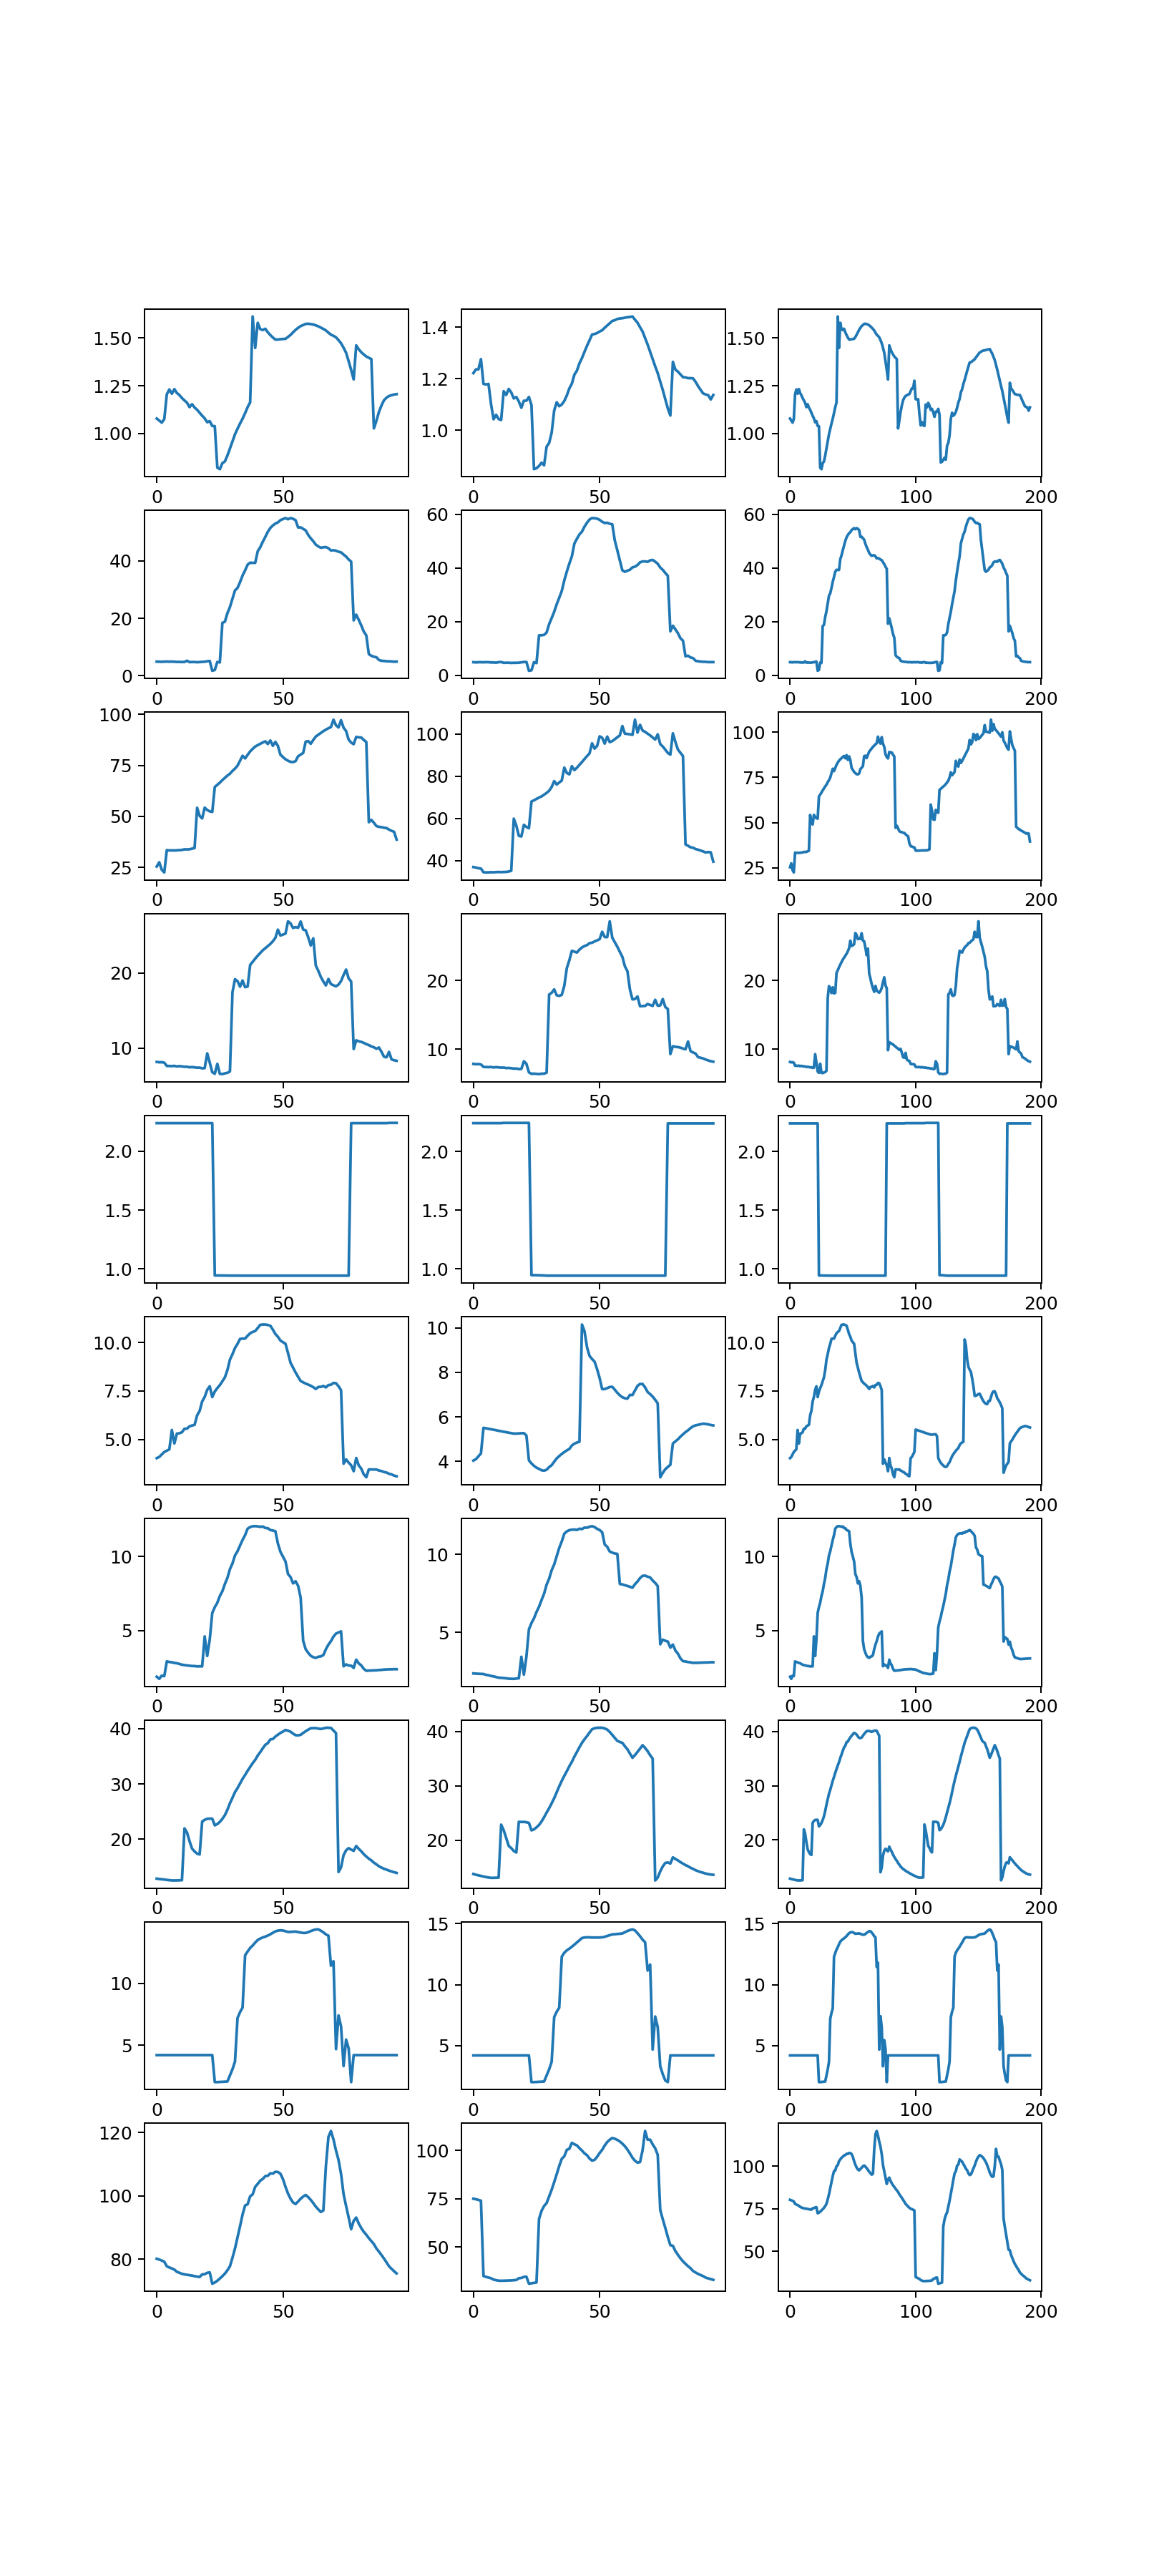

In [17]:
plt.subplots(10,3, figsize = (9,20))
for i in range(0,30,3):
    plt.subplot(10,3,i+1)
    bld = np.random.randint(0,blds)
    day = np.random.randint(0,num_days)
    plt.plot(data_days[bld,day,:])
    plt.subplot(10,3,i+2)
    plt.plot(data_days[bld,day+1,:])
    plt.subplot(10,3,i+3)
    plt.plot(two_days[bld,day,:])

In [35]:
def riseNfall(above,below):
    above = list((above))
    below = list((below))
    jumps = []
    ai,bi = 0,0
    start = True
    while (ai < len(above) and bi < len(below)):
        if above[ai] < below[bi]:
            jumps += [[above[ai], 1]]
            ai += 1
        else:
            jumps += [[below[bi], -1]]
            bi += 1
    jumps = np.asarray(jumps)
    rise,fall = 0,0
    for j in range(1,len(jumps)):
        if jumps[j,1] + jumps[j - 1, 1] == 0:
            diff = jumps[j,0] - jumps[j - 1, 0]
            if jumps[j, 1] < 0:
                fall = (diff)
            else:
                rise = (diff)
        if rise > 0 and fall > 0:
            break
    return jumps, rise,fall

<IPython.core.display.Javascript object>


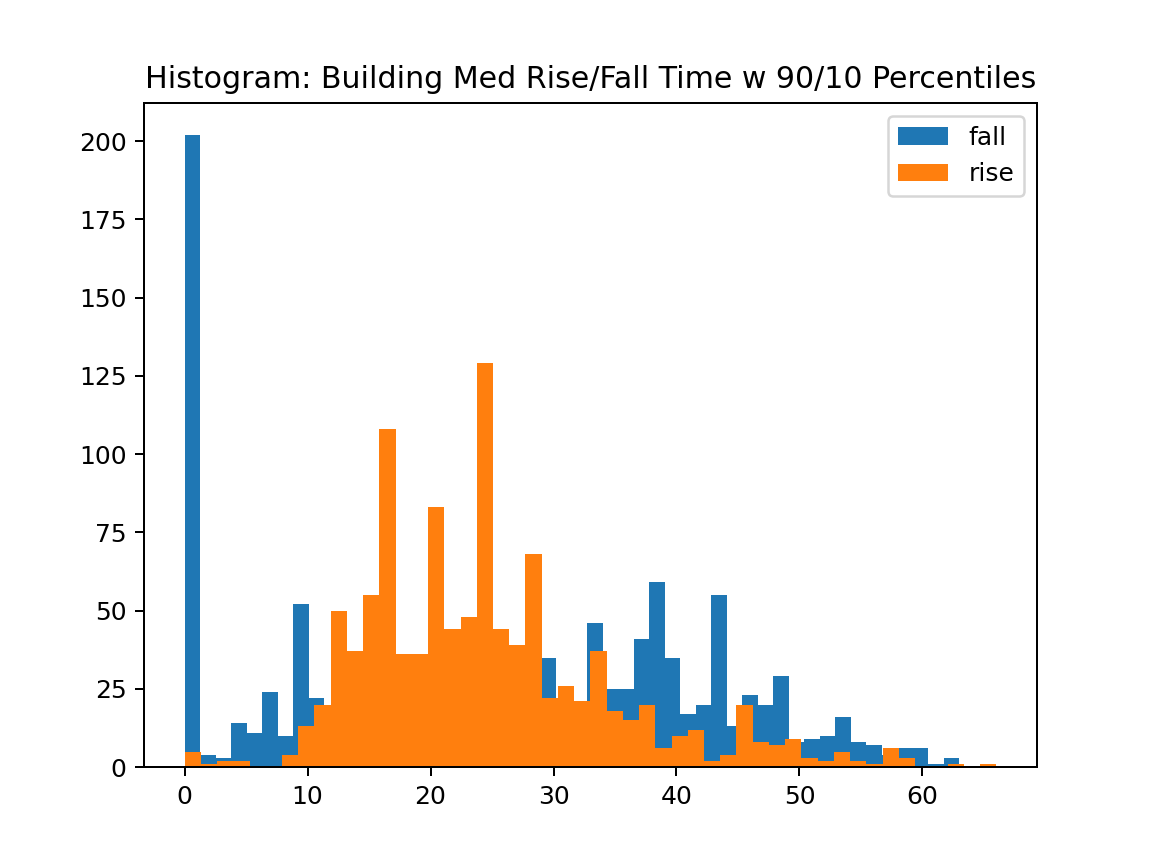

In [41]:
n_peak = np.percentile(two_days,90,axis=2,keepdims=True)
n_base = np.percentile(two_days,10,axis=2,keepdims=True)
high_load_dur = np.sum((two_days>=.5*(n_peak+n_base)).astype(int),axis=(1,2),keepdims=True)

rise_times_days = np.zeros((blds,num_days-1))
fall_times_days = np.zeros((blds,num_days-1))
records = {}
for b in range(blds):
    records[b] = []
    for d in range(num_days-1):
        arr = two_days[b,d,:]
        above_peak = (arr>=n_peak[b,d,0]).astype(int)
        below_base = (arr<=n_base[b,d,0]).astype(int) 
        above_ind = np.nonzero(above_peak)[0]
        below_ind = np.nonzero(below_base)[0]
        jumps,rise,fall = riseNfall(above_ind,below_ind)
        rise_times_days[b,d] = rise
        fall_times_days[b,d] = fall
        records[b].append(jumps)
        
fall_times = np.median(fall_times_days,axis=1)
rise_times = np.median(rise_times_days,axis=1)

plt.hist(fall_times, bins = 50)
plt.hist(rise_times, bins = 50)
plt.legend(['fall','rise'])
plt.title('Histogram: Building Med Rise/Fall Time w 90/10 Percentiles')
plt.show()

<IPython.core.display.Javascript object>


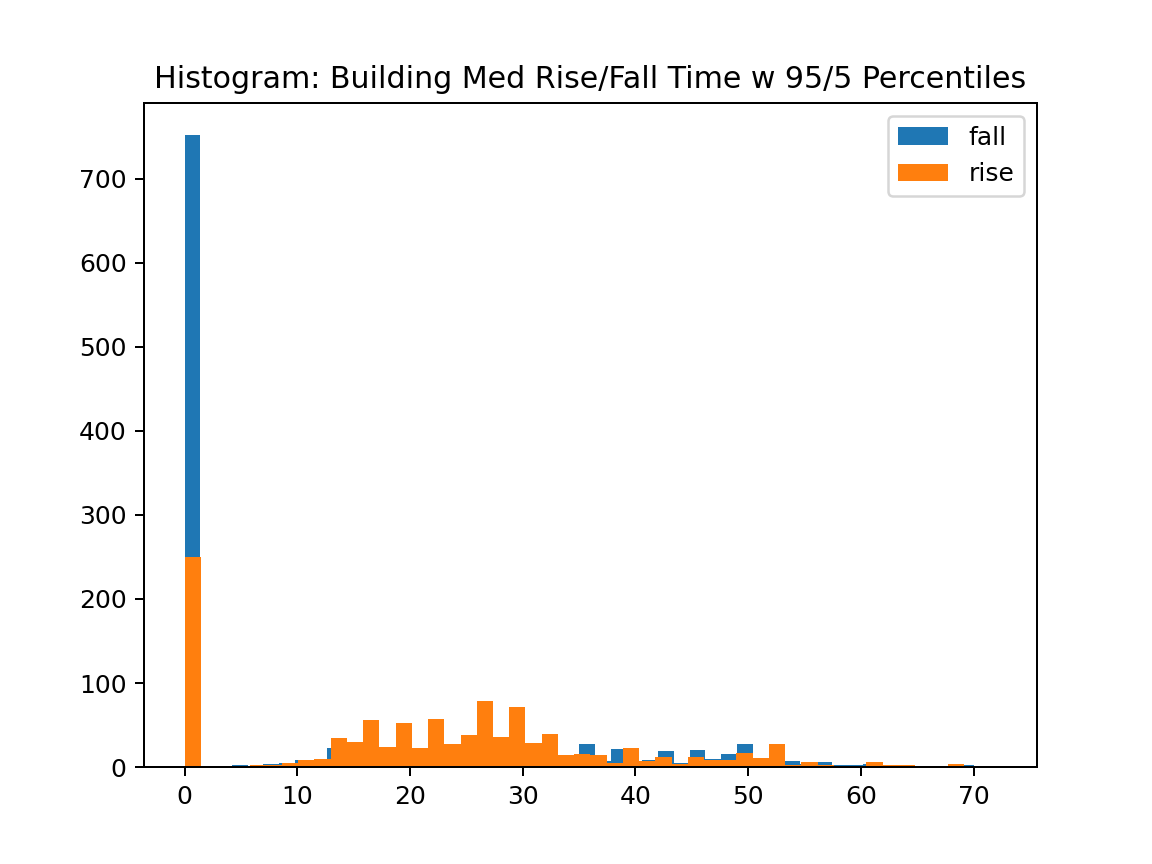

In [42]:
n_peak = np.percentile(two_days,95,axis=2,keepdims=True)
n_base = np.percentile(two_days,5,axis=2,keepdims=True)
high_load_dur = np.sum((two_days>=.5*(n_peak+n_base)).astype(int),axis=(1,2),keepdims=True)

rise_times_days = np.zeros((blds,num_days-1))
fall_times_days = np.zeros((blds,num_days-1))
records = {}
for b in range(blds):
    records[b] = []
    for d in range(num_days-1):
        arr = two_days[b,d,:]
        above_peak = (arr>=n_peak[b,d,0]).astype(int)
        below_base = (arr<=n_base[b,d,0]).astype(int) 
        above_ind = np.nonzero(above_peak)[0]
        below_ind = np.nonzero(below_base)[0]
        jumps,rise,fall = riseNfall(above_ind,below_ind)
        rise_times_days[b,d] = rise
        fall_times_days[b,d] = fall
        records[b].append(jumps)
        
fall_times = np.median(fall_times_days,axis=1)
rise_times = np.median(rise_times_days,axis=1)

plt.hist(fall_times, bins = 50)
plt.hist(rise_times, bins = 50)
plt.title('Histogram: Building Med Rise/Fall Time w 95/5 Percentiles')
plt.legend(['fall','rise'])
plt.show()

## Some buildings are just bad

In [40]:
ztimes = [[],[]]
for b in range(blds):
    if rise_times[b]==0:
        ztimes[0].append(b)
    if fall_times[b]==0:
        ztimes[1].append(b)
pad = len(ztimes[0])-len(ztimes[1])
if pad>0:
    ztimes[1].extend([-1]*pad)
else:
    ztimes[0].extend([-1]*-pad)
ztimes = np.asarray(ztimes).T
    

In [41]:
ztimes

array([], shape=(0, 2), dtype=float64)

In [ ]:
records[20]

In [ ]:
records[15]

In [ ]:
plt.plot(two_days[15,0,:]),n_peak[15,0],n_base[15,0]

In [ ]:
%matplotlib inline
for k in ztimes[:5,0]:
    plt.plot(data[k,:24*4*4])
    plt.show()
    

In [ ]:
plt.plot(data[34,:24*8])

In [ ]:
data.shape

In [ ]:

#     was = jumps[0][1]
#     idx = 1
#     while jumps[idx][1]==was:
#         idx+=1
#     if was=='a':
#         fall = jumps[idx][0]-jumps[idx-1][0]
#     else:
#         rise = jumps[idx][0]-jumps[idx-1][0]
#     was = jumps[idx][1]
#     idx+=1
#     while idx<len(jumps) and jumps[idx][1]==was:
#         idx+=1
#     if was=='a':
#         fall = jumps[idx][0]-jumps[idx-1][0]
#     else:
#         rise = jumps[idx][0]-jumps[idx-1][0]
        
    return jumps, rise,fall
        
        

In [ ]:
riseNfall(above_ind, below_ind)

In [ ]:
blds_bad_days = np.sum((rise_times==0).astype(int),axis=1)

In [ ]:
plt.hist(blds_bad_days)

In [ ]:
np.sum((rise_times==0).astype(int))

### the issue is that the low point occurs AFTER the peak in some buildings for every day in the data. Either I define two low points  OR I only use buildings without this issue

In [ ]:
'''
make int bool where greater than peak
same for below base
np argwhere to get indices
first index of above peak
make mask such that any larger index is 0
last index of below base after mask
difference between indices
average over all days for building
IF there is no peak or base, act like day missing
'''    

In [ ]:
n_bases = np.zeros((blds,num_days,2))
n_bases[:,:,0] = np.percentile(data_days[:,:,:24*2],10,axis=2)
n_bases[:,:,1] = np.percentile(data_days[:,:,24*2:],10,axis=2)
n_bases_avg = np.mean(n_bases,axis=1)
n_bases_avg
# so now we have a 5th percentile for the first half and last half of the day, this might help

In [ ]:
rise_times = np.zeros((blds,1))
fall_times = np.zeros((blds,1))
for b in range(blds):
    good_days=1
    good_days_f=1
    all_rise = 0
    all_fall = 0
    for d in range(num_days):
        above_peak = (data_days[b,d,:]>n_peak[b]).astype(int)
        below_base = (data_days[b,d,:]<n_bases_avg[b,0]).astype(int)
        below_base_f = (data_days[b,d,:]<n_bases_avg[b,1]).astype(int)
        if(np.sum(above_peak)>0):             
            above_ind = np.nonzero(above_peak)[0][0]
            mask = (np.arange(24*4)<above_ind).astype(int)
            mask_f = (mask*-1)+1
            if (np.sum(below_base*mask)>0): #rise case
                good_days+=1
                below_ind = np.nonzero(below_base*mask)[0][-1]
                all_rise += above_ind-below_ind
            if (np.sum(below_base_f*mask_f)>0): # fall case
                good_days_f+=1
                fall_ind = np.nonzero(below_base_f*mask_f)[0][-1]
                all_fall += fall_ind-above_ind
    rise_times[b] = all_rise/good_days
    fall_times[b] = all_fall/good_days_f

        

In [ ]:
print(blds -np.sum((rise_times==0).astype(int)),blds-np.sum((fall_times==0).astype(int)))
good_blds = (rise_times>0).astype(int)*(fall_times>0).astype(int)
np.sum(good_blds)

In [ ]:
arg_blds = np.nonzero(good_blds)
good_data = data[arg_blds[0]]
good_data.shape

In [ ]:
params = np.concatenate([
    n_peak,n_bases_avg,high_load_dur,
    rise_times,fall_times
    ],axis=1)[arg_blds[0]]

In [ ]:
params_n =(params-np.mean(params,axis=0))/np.std(params,axis=0)

In [ ]:
good_clust = {}

In [ ]:
for i in np.random.randn(100)*4:
    eps = np.round(np.exp(i),6)
    
    clust = DBSCAN(eps=eps).fit(params_n)
    #print(np.round(eps,4),set(clust.labels_))
    if len(set(clust.labels_)) > 2:
        good_clust[eps]=clust

In [ ]:
good_clust.keys()

In [ ]:
eps_dbis = np.zeros((len(good_clust.keys()),2))
count = 0
for k in good_clust.keys():
    eps_dbis[count,1] = davies_bouldin_score(params_n, good_clust[k].labels_)
    eps_dbis[count,0] = k
    count+=1
eps_dbis

In [ ]:
plt.scatter(eps_dbis[:,0],eps_dbis[:,1])
plt.xlabel('eps')
plt.ylabel('dbi')

## kmeans


In [ ]:
k_dbi = np.zeros(498)
for i in np.arange(2,500):
    clust = KMeans(n_clusters=i,random_state=0).fit(params_n)
    k_dbi[i-2] =  davies_bouldin_score(params_n, clust.labels_)
    

In [ ]:
plt.scatter(np.arange(2,500),k_dbi)

In [ ]:
KMeans?

In [ ]:
set(good_clust[1.28072].labels_)

In [ ]:
set(good_clust[0.162233].labels_)

In [ ]:
tr = get_top_month(df)

In [ ]:
trM = np.asarray(tr,dtype='float16').T

In [ ]:
def plotem(labels, M, axes = ['std','tmax','max'] ):
    COLORS = ['r','g','b','y','m','k','c']
    #labels as provided by the labels_ from DBSCAN
    #M a tall matrix where each row is a coordinate triple
    #can handle up to seven clusters with the colors
    groups = {}
    fig = plt.figure(figsize = (5, 5))
    ax = plt.axes(projection ="3d")
    for k in range(len(set(labels))):
        i = list(set(labels))[k]
        groups[i] = np.array([M[j] for j in range(M.shape[0]) if labels[j]==i],dtype='float16')
        ax.scatter3D(groups[i][:,0],groups[i][:,1],groups[i][:,2],
                     color = COLORS[i%len(COLORS)])
    ax.set_xlabel(axes[0])
    ax.set_ylabel(axes[1])
    ax.set_zlabel(axes[2])
    ax.set_title(str(len(set(labels)))+' clusters' )
    plt.show()

In [ ]:
def plotem2D(labels, M, axes = ['max','tmax'],COLORS =COLORS):
    numColors = len(COLORS)
    #labels as provided by the labels_ from DBSCAN
    #M a tall matrix where each row is a coordinate triple
    #can handle up to seven clusters with the colors
    groups = {}
    labels = (labels).astype(int)
    plt.figure(figsize = (7, 7))
    numLabels = len(set(labels))
    leg =[]
    for k in range(numLabels):
        i = list(set(labels))[k]
        groups[i] = np.array([M[j] for j in range(M.shape[0]) if labels[j]==i],dtype='float16')
        leg+=[str(k)]
        plt.scatter(groups[i][:,0],groups[i][:,1],
                     color = COLORS[-2 -numColors//numLabels*k])
    plt.legend(leg)
    plt.xlabel(axes[0])
    plt.ylabel(axes[1])
    plt.title(str(len(set(labels)))+' clusters' )
    plt.show()

In [ ]:
%matplotlib inline

In [ ]:
COLORS = list(colors.CSS4_COLORS.keys())

In [ ]:
blds = trM.shape[0]

In [ ]:
maxs =np.reshape(np.max(trM,axis=1),(blds,1))
tmax = np.reshape(np.argmax(trM,axis=1)%96,(blds,1))
maxStats=np.concatenate([maxs,tmax],axis=1)
print(maxStats.shape,np.std(maxStats,axis=0))
maxStats3 = maxStats/np.std(maxStats,axis=0)
np.save('maxStats3',maxStats)

In [ ]:
def cluster_sizes(arr):
    for i in list(set(arr)):
        print(i,'has ',np.sum(arr==i),'elements')

## Clustering on tmax and max, scaled by std

### kmeans

In [ ]:
for n in range(8,9):
    kmeans = KMeans(n_clusters=n, random_state=0).fit(maxStats3)
    print('\nwith ',n, 'clusters')
    cluster_sizes(kmeans.labels_)
    plotem2D(kmeans.labels_,maxStats3)

In [ ]:
kmeans8 = KMeans(n_clusters=8, random_state=0).fit(maxStats3)
kmeans9 = KMeans(n_clusters=9, random_state=0).fit(maxStats3)
kmeans10 = KMeans(n_clusters=10, random_state=0).fit(maxStats3)


In [ ]:
np.save('maxStd8_clust',kmeans8.labels_)
np.save('maxStd9_clust',kmeans9.labels_)
np.save('maxStd10_clust',kmeans10.labels_)

## what about letting tmax be something else, like the time of day that most often has the maximum? time of day for monthly maximum seems like a lot

In [ ]:
dailyM = np.reshape(trM,(blds,30,96))

In [ ]:
modeObj = scipy.stats.mode(((np.argmax(dailyM,axis=2))//4)*4,axis=1)

In [ ]:
modes = modeObj[0].astype('int16')

In [ ]:
modes.shape

In [ ]:
plt.hist(modeObj[1],bins=30)

In [ ]:
avgMax = np.reshape(np.max(np.mean(dailyM,axis=1),axis= 1),(blds,1)).astype('float16')

In [ ]:
stats4 = np.concatenate([avgMax,modes],axis=1)
np.save('stats4',stats4)

In [ ]:
stats4n = stats4/np.std(stats4,axis=0)

In [ ]:
for n in range(8,9):
    kmeans = KMeans(n_clusters=n, random_state=0).fit(stats4n)
    print('\nwith ',n, 'clusters')
    cluster_sizes(kmeans.labels_)
    plotem2D(kmeans.labels_,stats4n)

In [ ]:
kmeans8 = KMeans(n_clusters=8, random_state=0).fit(stats4n)

In [ ]:
np.save('robustMax_clust',kmeans8.labels_)